# X Sentiment Analysis Using CNN

## Introduction
Sentiment analysis is a technique used to determine the emotional tone from remarks or comments that users of certain application either X, facebook, instagram or tiktok about a certain topic.

This remarks can have a positive tone, neutral tone and negative tone towards a certain audience.



## Business Understanding


### Background
X is a popular social media platform that most people use to share their opinions about certain topics, this can either be political, religious or social trends.

These opinions can be positive, negative or neutral towards the topic been addressed. These opinions are mainly in text format.


### Problem statement
Due to the growing amount of user-generated content on X, it is becoming more difficult for researchers, corporation to accurately and efficiently gauge public opinion on particular subjects, goods, or occasions. It's challenging to glean useful data from tweets because of their sheer number and informal style, which frequently includes slang, acronyms, and emoticons. This leads to inadequate insights generated by corporations from public opinion to improve certain products or when advertising certain products.

### Objective
1. Develop a sentiment analysis model that uses natural preprocessing language(nlp) to preprocess and clean the tweets, and make it in a more structured format for sentiment analysis.

2. Use the sentiment analysis model that can accurately classify tweets into positive, negative and neutral sentiment categories.

3. Evaluate Performance: Measure the model's accuracy, precision, recall, and F1-score on a labeled dataset, and iteratively improve based on evaluation results.

### Conclusion
Although emojis, acronyms, and slang are common on Twitter, the informal tone of the network makes it difficult to draw meaningful conclusions from user-generated content. While sophisticated NLP models and neural network approaches, handle the complexity of sentiment grouping, preprocessing is essential to cleanse this noisy data.









## Data Understanding

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install datasets

### Loading the data

In [3]:
from datasets import load_dataset

ds = load_dataset("mteb/tweet_sentiment_extraction")

In [4]:
dataset = load_dataset("mteb/tweet_sentiment_extraction")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [6]:
train_data = dataset['train']
# Convert the dataset to a DataFrame
train_df = pd.DataFrame(train_data)

train_df.head()

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative


In [7]:
# checking the columns
train_df.columns

Index(['id', 'text', 'label', 'label_text'], dtype='object')

In [8]:
# size of the dataframe
train_df.shape

(27481, 4)

In [9]:
# preview a text
train_df['text'][1500]

'This wind is crampin` my style. I have a section of my yard that won`t get any water. I`d move the sprinkler, but it`s surrounded by mud.'

In [10]:
# value counts of the sentiments
train_df['label_text'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: label_text, dtype: int64

In [11]:
# summary information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          27481 non-null  object
 1   text        27481 non-null  object
 2   label       27481 non-null  int64 
 3   label_text  27481 non-null  object
dtypes: int64(1), object(3)
memory usage: 858.9+ KB


### Handling Missing Values

We want to ensure there are no missing tweets or sentiment labels in the dataset before preprocessing.

In [12]:
# Checking for missing values
missing_values = train_df.isnull().sum()
if missing_values.sum() == 0:
    print('There are no missing values')
else:
    print('Check for the missing values')

There are no missing values


### Class Distribution

A bar plot showing the distribution of classes (negative, neutral, positive) can give us insight into whether our dataset is balanced or imbalanced.

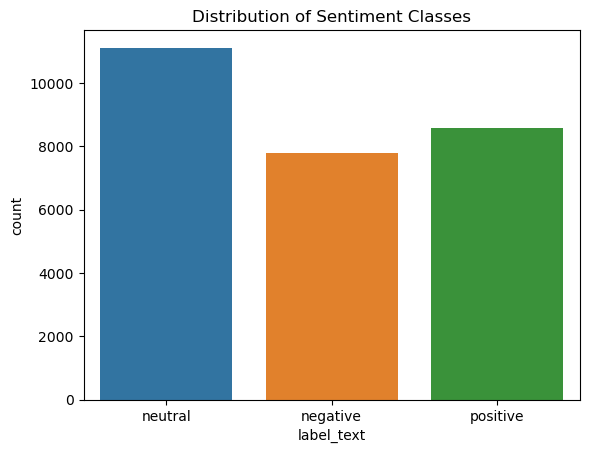

In [13]:
# Plot class distribution
sns.countplot(x='label_text', data=train_df)
plt.title('Distribution of Sentiment Classes')
plt.show()

It shows that the neutral class is the most common sentiment in our dataset, followed by negative and positive sentiments.

## Data Preparation

### Text Preprocessing

In [14]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# display stopwords
print(stop_words)

{'once', 'those', 'not', 'both', 'into', 'up', 'it', 'against', 'which', "mightn't", 'shan', 'does', 'ours', 'most', "doesn't", "you're", 'these', 'do', 'who', 'with', 'now', 'didn', 'doesn', 'after', 're', 'ourselves', 'because', 'has', 'in', 'so', 'each', 'my', 'myself', 'm', 'hers', 'this', 'above', "you'll", 'wasn', 'over', 'hasn', 'needn', 'him', 'the', 'from', 'than', "don't", 'such', 'through', 'themselves', 'be', "won't", 'were', 'only', 'theirs', 'under', 'same', 'himself', 'on', 'just', 'wouldn', "couldn't", 'being', 've', 'i', 'before', 'out', "shouldn't", 'd', 'did', 'our', 'when', 'where', "wouldn't", 'shouldn', 'then', 'nor', 'having', 'all', "haven't", 'mightn', 'itself', 'an', 'by', 'if', "you've", 'had', 'at', 'and', 'aren', 'mustn', 'but', 'his', 'own', 'weren', "needn't", 'between', 'll', 'herself', "hasn't", 'further', "that'll", 'me', 'isn', 'been', 'more', 'below', 'haven', 'about', 'what', 'a', 'again', 'whom', 'couldn', 'few', "wasn't", 'won', 'your', 'too', "di

In [16]:
def preprocess_text(text) -> str:
  """
  Function to clean and preprocess the text
  """
  contractions_dict = {
        "shouldve": "should have",
        "wouldve": "would have",
        "couldve": "could have",
        "mightve": "might have",
        "mustve": "must have",
        "dont": "do not",
        "doesnt": "does not",
        "didnt": "did not",
        "cant": "cannot",
        "couldnt": "could not",
        "wont": "will not",
        "wouldnt": "would not",
        "isnt": "is not",
        "arent": "are not",
        "wasnt": "was not",
        "werent": "were not",
        "havent": "have not",
        "hasnt": "has not",
        "hadnt": "had not",
        "neednt": "need not",
        "shant": "shall not",
        "shouldnt": "should not",
        "mustnt": "must not",
        "youre": "you are",
        "theyre": "they are",
        "its": "it is",
        "were": "we are",
        "hes": "he is",
        "shes": "she is",
        "id": "i would"
    }
  
  for contraction, expanded in contractions_dict.items():
      text = text.replace(contraction, expanded)
 
  # lower case
  text = text.lower()
  # remove html tags
  text = re.sub(r'<.*?>', '', text)
  # remove non-alphabetical
  text = re.sub(r'[^a-z\s]', '', text)
  # remove stop words
  text = ' '.join([word for word in text.split() if word not in stop_words])
  # remove mentions
  text = re.sub(r'@\w+', '', text)
  # remove html links
  text = re.sub(r'http\S+|www.\S+', '', text)
  # replace elongated words (e.g., "sooooo" -> "so")
  text = re.sub(r'\b(\w*?)([aeiou])\2{2,}(\w*?)\b', r'\1\2\3', text)  # Improved regex for vowels
  # remove possessives (e.g., "ann's" -> "ann")
  text = re.sub(r"\b(\w+)'s\b", r'\1', text)

  return text



In [17]:
# apply to the text column
train_df['text'] = train_df['text'].apply(preprocess_text)

In [18]:
# preview a text after preprocessing
train_df['text'][1500]

'wind crampin style section yard wont get water id move sprinkler surrounded mud'

In [19]:
train_df.shape

(27481, 4)

### Tokenization and Padding

In [20]:
# tokenize the 'text' column
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
print(f'Vocabulary size: {len(word_index)}')

Vocabulary size: 26002


In [21]:
# Convert texts to sequences
X = tokenizer.texts_to_sequences(train_df['text'])

In [22]:
# before padding - train data
np.shape(X)

(27481,)

In [23]:
# Defining a max length for truncating the sequences.
max_len = 500
X = pad_sequences(X, maxlen=max_len)

In [24]:
# after padding - train data
np.shape(X)

(27481, 500)

In [25]:
# Extract the target labels (sentiment) from the 'label' column in the dataset
# This will be used as the dependent variable.
y = train_df['label'].values

In [26]:
np.shape(y)

(27481,)

### Distribution of Sequence Lengths

After padding, we check the distribution of the lengths of sequences (the number of tokens per sample).This helps ensure that our padding or truncation strategy is appropriate.

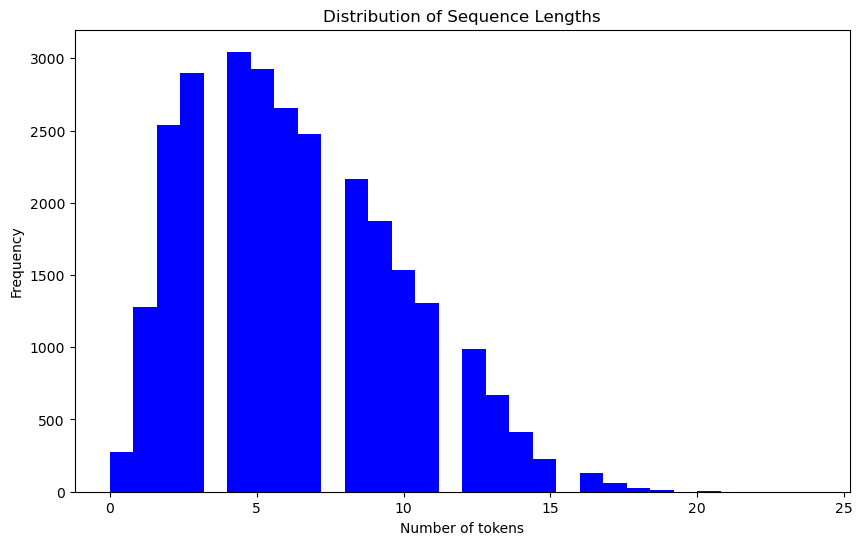

In [27]:
# Get the length of each sequence (before padding)
seq_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train_df['text'])]

# Plot distribution of sequence lengths
plt.figure(figsize=(10,6))
plt.hist(seq_lengths, bins=30, color='blue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.show()

The distribution plot of sequence lengths shows that the majority of text samples have between 2 and 10 tokens, with a peak around 4-6 tokens. The distribution tail suggests that some samples have longer sequences, though fewer of them exceed 15 tokens.

### Loading the test data

In [28]:
test_data = dataset['test']
# Convert the dataset to a DataFrame
test_df = pd.DataFrame(test_data)

test_df.head()

,id,text,label,label_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,2,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,negative
3,01082688c6,happy bday!,2,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2,positive


In [29]:
#checking the columns 
test_df.columns

Index(['id', 'text', 'label', 'label_text'], dtype='object')

In [30]:
# size of the dataframe
test_df.shape

(3534, 4)

In [31]:
# preview a text
test_df['text'][1600]

'At anthony`s for prom.'

In [32]:
# value counts of the sentiments
test_df['label_text'].value_counts()

neutral     1430
positive    1103
negative    1001
Name: label_text, dtype: int64

In [33]:
# summary information
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3534 non-null   object
 1   text        3534 non-null   object
 2   label       3534 non-null   int64 
 3   label_text  3534 non-null   object
dtypes: int64(1), object(3)
memory usage: 110.6+ KB


### Handling Missing Values

We want to ensure there are no missing tweets or sentiment labels in the dataset before preprocessing.

In [34]:
# Checking for missing values
missing_values1 = test_df.isnull().sum()
if missing_values1.sum() == 0:
    print('There are no missing values')
else:
    print('Check for the missing values')

There are no missing values


### Class Distribution test data

A bar plot showing the distribution of classes (negative, neutral, positive) can give us insight into whether our dataset is balanced or imbalanced.



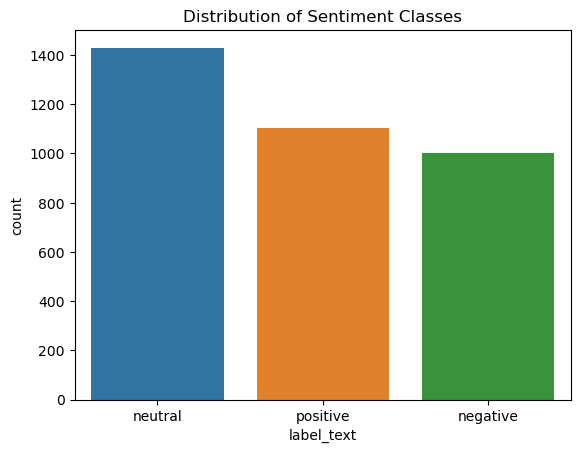

In [35]:
# Plot class distribution
sns.countplot(x='label_text', data=test_df)
plt.title('Distribution of Sentiment Classes')
plt.show()

It shows that the neutral class is the most common sentiment in our dataset, followed by negative and positive sentiments.

## Data Preparation

### Text Preprocessing

In [36]:
# apply to the test text column
test_df['text'] = test_df['text'].apply(preprocess_text)

In [37]:
# preview a text after preprocessing
test_df['text'][1700]

'so hungry right shouldve eaten wedding'

### Tokenization and Padding

Test data should be treated as unseen data in the model.

For our test data, we avoid fitting it to the tokenizer to prevent overfitting and data leakage

In [38]:
# Convert texts to sequences
X_test = tokenizer.texts_to_sequences(test_df['text'])

In [39]:
# before padding - test data
np.shape(X_test)

(3534,)

In [40]:
# Defining a max length for truncating the sequences.
max_len = 500
X_test = pad_sequences(X_test, maxlen=max_len)

In [41]:
# after padding - test data
np.shape(X_test)

(3534, 500)

In [42]:
# Extract the target labels (sentiment) from the 'label' column in the dataset
# This will be used as the dependent variable.
y_test = test_df['label'].values

In [43]:
y_test.shape

(3534,)

### Distribution of Sequence Lengths
After padding, we check the distribution of the lengths of sequences (the number of tokens per sample).This helps ensure that our padding or truncation strategy is appropriate.


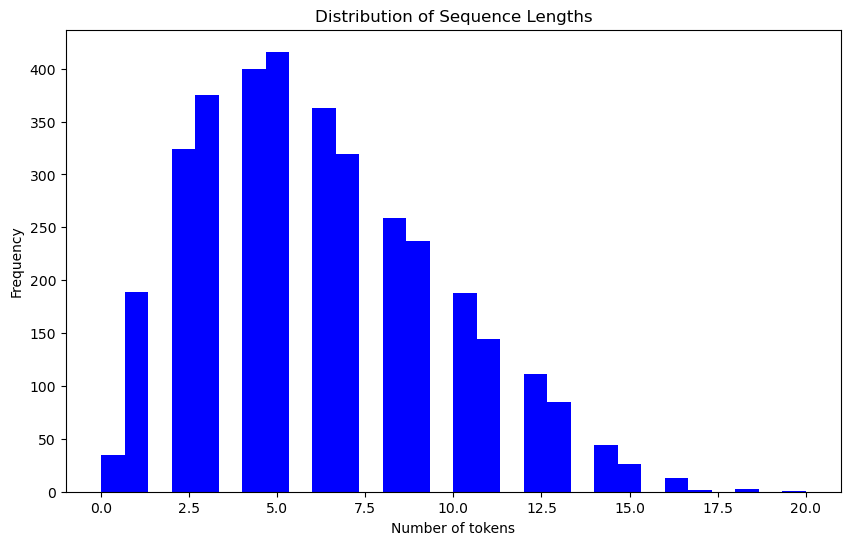

In [44]:
# Get the length of each sequence (before padding)
seq_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(test_df['text'])]

# Plot distribution of sequence lengths
plt.figure(figsize=(10,6))
plt.hist(seq_lengths, bins=30, color='blue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.show()

The distribution plot of sequence lengths shows that the majority of text samples have between 2 and 10 tokens, with a peak around 4-6 tokens. The distribution tail suggests that some samples have longer sequences, though fewer of them exceed 15 tokens.

### CNN Base Model

In [62]:
# Libraries for modelling
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Dropout, GlobalMaxPooling1D, Bidirectional, LSTM


In [46]:
model = Sequential()

In [47]:
# embedding layer to learn word embeddings
model.add(Embedding(input_dim=5001, output_dim=128, input_length=max_len))

# 1D convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

# GlobalMaxPooling to reduce dimensionality
model.add(GlobalMaxPooling1D())

# fully connected layers
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))  # output layer for multiple classification

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          640128    
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 128)          49280     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 690,731
Trainable params: 690,731
Non-trainable params: 0
_________________________________________________________________


In [77]:
# fitting our data to the model
model_one_history = model.fit(X, y, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
430/430 [==============================] - 108s 251ms/step - loss: 0.1705 - accuracy: 0.9479 - val_loss: 1.0884 - val_accuracy: 0.6896
Epoch 2/5
430/430 [==============================] - 105s 245ms/step - loss: 0.1198 - accuracy: 0.9638 - val_loss: 1.2253 - val_accuracy: 0.6904
Epoch 3/5
430/430 [==============================] - 105s 245ms/step - loss: 0.0909 - accuracy: 0.9730 - val_loss: 1.3697 - val_accuracy: 0.6802
Epoch 4/5
430/430 [==============================] - 110s 256ms/step - loss: 0.0707 - accuracy: 0.9793 - val_loss: 1.4953 - val_accuracy: 0.6692
Epoch 5/5
430/430 [==============================] - 113s 264ms/step - loss: 0.0605 - accuracy: 0.9824 - val_loss: 1.5941 - val_accuracy: 0.6743


#### Evaluating the Model

In [79]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

111/111 [==============================] - 4s 32ms/step - loss: 1.5941 - accuracy: 0.6743
Test Loss: 1.5941
Test Accuracy: 67.43%


#### Visualizing loss and accuracy with comparison with validation accuracy and loss

In [72]:
# create a function to handle our viz
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

CNN Base Model Visualization

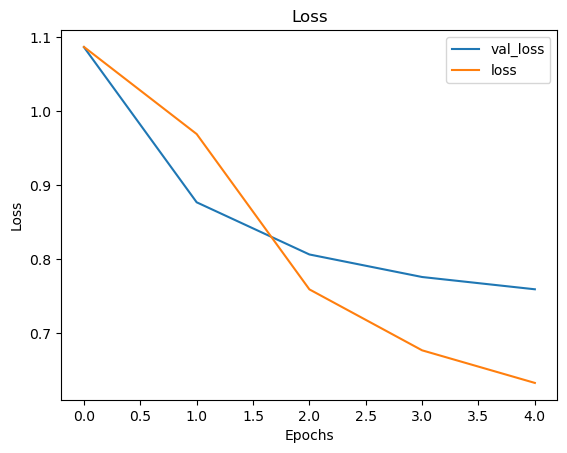

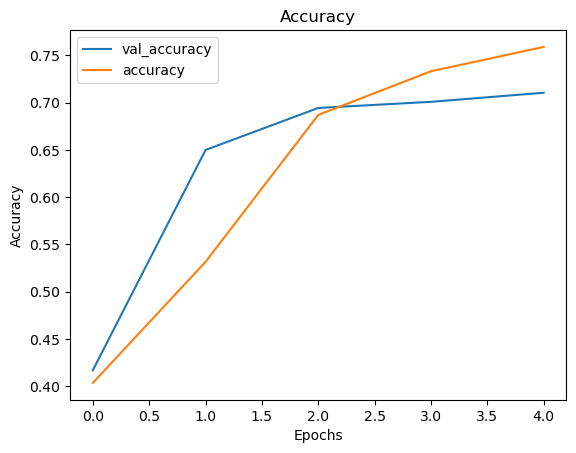

In [73]:
# plot the cnn base model -> Loss and Accuracy
visualize_training_results(model_one_history) 

#### Model 2

In [58]:
second_model = Sequential()

# embedding layer to learn word embeddings
second_model.add(Embedding(input_dim=5001, output_dim=128, input_length=max_len))

#convolutional layer 
second_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Max Pooling Layer
second_model.add(MaxPooling1D(pool_size=4))

# Flatten Output
second_model.add(Flatten())

# Fully Connected Layer
second_model.add(Dense(128, activation='relu'))

#Regularization
second_model.add(Dropout(0.35))

# Output Layer
second_model.add(Dense(3, activation='softmax'))

# Compiling the second_model
second_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
second_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          640128    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 498, 64)           24640     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7936)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1015936   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [74]:
# fitting our data to the second model
model_two_history = second_model.fit(X, y, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
430/430 [==============================] - 84s 195ms/step - loss: 0.4273 - accuracy: 0.8245 - val_loss: 1.4084 - val_accuracy: 0.5555
Epoch 2/5
430/430 [==============================] - 85s 199ms/step - loss: 0.3595 - accuracy: 0.8520 - val_loss: 1.5884 - val_accuracy: 0.5509
Epoch 3/5
430/430 [==============================] - 92s 215ms/step - loss: 0.3197 - accuracy: 0.8666 - val_loss: 1.8975 - val_accuracy: 0.5487
Epoch 4/5
430/430 [==============================] - 80s 187ms/step - loss: 0.2958 - accuracy: 0.8750 - val_loss: 2.0504 - val_accuracy: 0.5492
Epoch 5/5
430/430 [==============================] - 82s 190ms/step - loss: 0.2794 - accuracy: 0.8804 - val_loss: 2.2444 - val_accuracy: 0.5467


#### Evaluating the Model

In [75]:
loss, accuracy = second_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

111/111 [==============================] - 3s 24ms/step - loss: 2.2444 - accuracy: 0.5467
Test Loss: 2.2444
Test Accuracy: 54.67%


Second Model Visualization

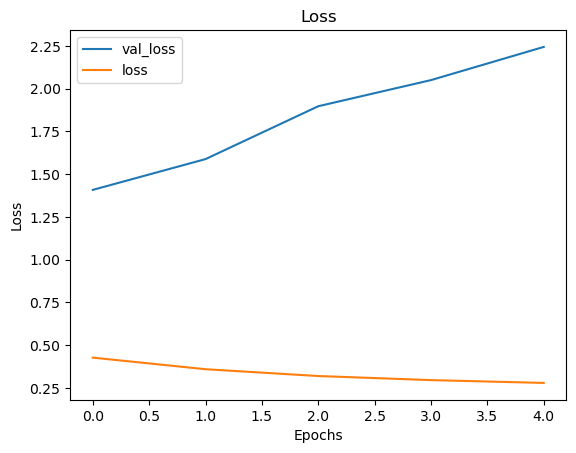

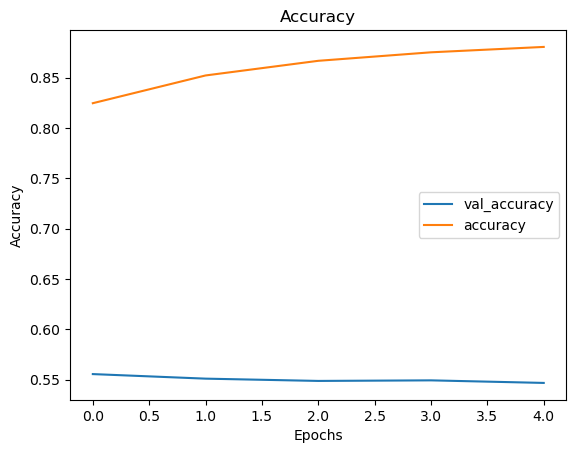

In [76]:
# plot the second model -> Loss and Accuracy
visualize_training_results(model_two_history) 

#### Model 3

In [63]:
# Create the model
third_model = Sequential()
# Embedding layer to learn word embeddings
third_model.add(Embedding(input_dim=5001, output_dim=128, input_length=max_len))

# 1D convolutional layer
third_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
third_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Bidirectional LSTM for capturing sequence context
third_model.add(Bidirectional(LSTM(64, return_sequences=True)))
third_model.add(Dropout(0.5))

# GlobalMaxPooling to reduce dimensionality
third_model.add(GlobalMaxPooling1D())

# Fully connected layers
third_model.add(Dense(64, activation='relu'))
third_model.add(Dropout(0.5))  # Dropout for further regularization
third_model.add(Dense(3, activation='softmax'))  # Output layer for multi-class classification

# Compile the model with sparse categorical crossentropy
third_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [64]:
third_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          640128    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 498, 128)          49280     
_________________________________________________________________
dropout_3 (Dropout)          (None, 498, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 498, 128)          98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 498, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [65]:
# fitting our data to the third model
history = third_model.fit(X, y, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
430/430 [==============================] - 906s 2s/step - loss: 1.0872 - accuracy: 0.4034 - val_loss: 1.0869 - val_accuracy: 0.4168
Epoch 2/5
430/430 [==============================] - 747s 2s/step - loss: 0.9695 - accuracy: 0.5316 - val_loss: 0.8772 - val_accuracy: 0.6500
Epoch 3/5
430/430 [==============================] - 795s 2s/step - loss: 0.7595 - accuracy: 0.6871 - val_loss: 0.8067 - val_accuracy: 0.6944
Epoch 4/5
430/430 [==============================] - 715s 2s/step - loss: 0.6771 - accuracy: 0.7333 - val_loss: 0.7762 - val_accuracy: 0.7009
Epoch 5/5
430/430 [==============================] - 733s 2s/step - loss: 0.6330 - accuracy: 0.7590 - val_loss: 0.7596 - val_accuracy: 0.7105


#### Evaluating the Model

In [67]:
loss, accuracy = third_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

111/111 [==============================] - 16s 146ms/step - loss: 0.7596 - accuracy: 0.7105
Test Loss: 0.7596
Test Accuracy: 71.05%


Third Model Visualization

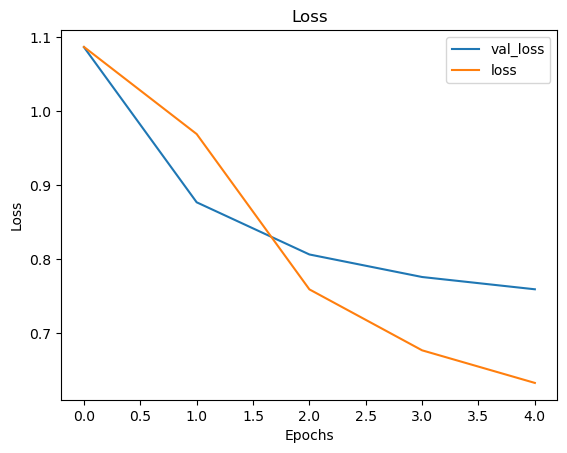

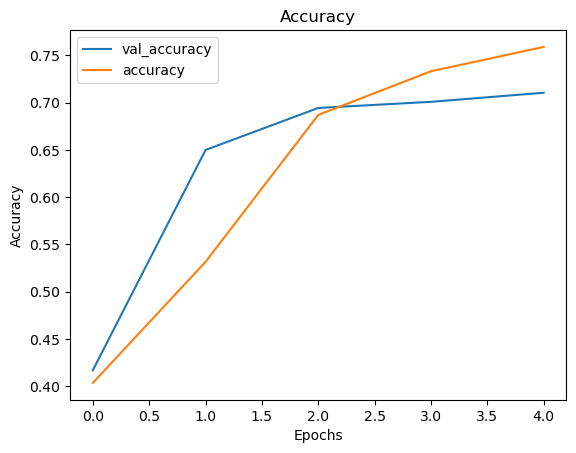

In [78]:
# plot the third model -> Loss and Accuracy
visualize_training_results(history)

##### The best Model

Model 3(third_model) is the best performing model among the three models build.

It proves its top perfomance by having a low Test Loss(0.7596) and a high Test Accuracy(71.05%) overall.

### Predict on Custom Tweets

In [68]:
def user_tweet():
  tweet = input('Enter a tweet:\n')
  return tweet

In [69]:
def predict_sentiment():
    tweet = user_tweet()
    # preprocess the input tweet
    tweet = preprocess_text(tweet)
    #tokenize and pad the input
    sequence = tokenizer.texts_to_sequences([tweet])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    # make prediction
    
    predictions = third_model.predict(padded_sequence)[0]
    print(predictions)  # Output: Array of probabilities, e.g., [0.1, 0.7, 0.2]
    predicted_class = np.argmax(predictions)

    print("Predicted Class:", predicted_class)

    # interpret the prediction
    if predicted_class == 0:
        return 'Negative'
    elif predicted_class == 1:
        return 'Neutral'
    else:
        return 'Positive'

In [70]:
predict_sentiment()

[0.04778629 0.12711155 0.82510215]
Predicted Class: 2


'Positive'

In [81]:
predict_sentiment()

[0.6466731  0.2541297  0.09919718]
Predicted Class: 0


'Negative'

In [82]:
predict_sentiment()

[0.26662007 0.53560793 0.19777207]
Predicted Class: 1


'Neutral'

#### Conclusion
After picking our final model model3, the model was tested on new unseen data and it was able to classify positive tweets as positive, negative tweets as negative and neutral tweets as neutral.